In [1]:
# Comparing my tensorflow implementation of the linear conjugate gradient method to the scipy.
# Since my implementation assumes float32 arrays, the accuracy of the results is going to be quite a bit lower.
# however, the output should be

In [2]:
import numpy as np
from scipy.sparse import linalg
import tensorflow as tf
from sopt.optimizers.tensorflow2.utils import MatrixFreeLinearOp, conjugate_gradient
import matplotlib.pyplot as plt

In [3]:
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Creating a linear system.

In [5]:
m = np.random.randn(20, 20)

A = m @ m.T

In [6]:
# Ensuring the matrix is symmetric and positive definite. All eigvals should be positive
np.linalg.eigvals(A)

array([5.43817692e+01, 5.09400120e+01, 4.41583093e+01, 3.83049090e+01,
       3.25243817e+01, 3.10047076e+01, 2.80352708e+01, 2.12035361e+01,
       1.83481097e+01, 1.49214291e+01, 9.89406746e+00, 7.68087440e+00,
       6.53350848e+00, 3.83570925e+00, 2.91556764e+00, 6.53391196e-03,
       3.79409181e-02, 1.03067332e+00, 1.52404207e+00, 1.30081563e+00])

In [7]:
A_precond = np.linalg.inv(A * 5 + 1)

In [8]:
x_true = np.random.randn(20)
y = (A @ x_true[:,None]).reshape(-1)
x0 = np.random.randn(20)

In [9]:
# Results using scipy
def getScipyErrors(maxiter):
    x_pred = linalg.cg(A, y, maxiter=maxiter, x0=x0)[0]
    pcg_x_pred = linalg.cg(A, y, maxiter=maxiter, M=A_precond, x0=x0)[0]
    errors = x_pred - x_true
    errors_pcg = pcg_x_pred - x_true
    return np.sum(errors**2), np.sum(errors_pcg**2)

In [10]:
# Using my conjugate gradient method

In [11]:
A_t = tf.constant(A, dtype='float32')
A_precond_t = tf.constant(A_precond, dtype='float32')
y_t = tf.constant(y, dtype='float32')
x_true_t = tf.constant(x_true, dtype='float32')
x0_t = tf.constant(x0, dtype='float32')

In [12]:
matvec = lambda x: tf.reshape(A_t @ x[:, None], [-1])
linop = MatrixFreeLinearOp(operator=matvec, shape=y_t.shape)

In [13]:
precond_matvec = lambda x: tf.reshape(A_precond_t @ x[:, None], [-1])
precond_linop = MatrixFreeLinearOp(operator=precond_matvec, shape=y_t.shape)

In [14]:
@tf.function
def cg_step(maxiter, precond=None):
    if precond is not None:
        x_pred_t = conjugate_gradient(linop, y_t, tol=1e-6, max_iter=maxiter, preconditioner=precond, x=x0_t)
    else:
        x_pred_t = conjugate_gradient(linop, y_t, tol=1e-6, max_iter=maxiter, x=x0_t)
    errors_t = x_pred_t.x - x_true_t
    lsq_errors_t = tf.reduce_sum(errors_t**2)
    return x_pred_t, errors_t, lsq_errors_t

In [15]:
%time 

lsq_errors_scipy = []
lsq_errors_pcg_scipy = []
lsq_errors_tf = []
lsq_errors_pcg_tf = []
for i in range(1,50):
    se1, se2 = getScipyErrors(i)
    lsq_errors_scipy.append(se1)
    lsq_errors_pcg_scipy.append(se2)
    _, __, e1 = cg_step(tf.convert_to_tensor(i))
    _, __, e2 = cg_step(tf.convert_to_tensor(i), precond=precond_linop)
    lsq_errors_tf.append(e1.numpy())
    lsq_errors_pcg_tf.append(e2.numpy())

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 28.8 µs


In [16]:
# The tensorflow results are less accurate after a point.

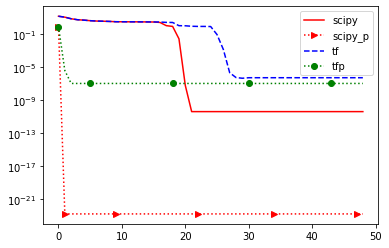

In [17]:
plt.plot(lsq_errors_scipy, color='red', label='scipy')
plt.plot(lsq_errors_pcg_scipy, color='red', ls=":", label='scipy_p', markevery=0.2, marker='>')
plt.plot(lsq_errors_tf, color='blue', ls='--', label='tf')
plt.plot(lsq_errors_pcg_tf, color='green', ls=':', label='tfp', markevery=0.2, marker='o')
plt.legend(loc='best')
plt.yscale('log')
#plt.ylim([1e-20, 5])
#plt.yscale('log')
plt.show()